In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import torch

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
np.argmax(val_accs)

38

In [5]:
np.argmin(val_losses)

44

In [8]:
classes = [0, 1, 2, 3]
class_labels = ["electron","muon","photon","proton"]

In [9]:
def calculate_tpr_fpr(y_real, y_pred):
    """
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    """
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr
    
def get_all_roc_coordinates(y_real, y_proba):
    """
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    """
    tpr_list = [0]
    fpr_list = [0]
    resolution = 50
    
    for i in range(resolution):
        threshold = i / resolution
#         threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    """
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    """
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
def plot_overlayed_roc_curve(classes, labels, predictions, class_labels, odir, label = '', ax = None, figsize=(9, 9), ncol=2):
    """
    Plots overlayed ROC curves and returns a list of AUC.
    
    Args:
        classes: The classes used in classification. Must match with the predictions and labels.
                 i.e., if predictions consists of [..., 1, 3, 2, 1, 4, ...], then your classes cannot be ['photon', 'hadron', 'lepton']
        labels: The list of labels.
        predictions: The list of predicted classes. First dimension should match with the dimension of labels
        class_labels: List of actual names of the classes (instead of 0, 1, ...)
    Return:
        roc_auc_ovr: Dictionary of AUC, one for each class
    """
#     assert labels.size() == predictions[:, 0].size()
    if predictions.type() == 'torch.cuda.FloatTensor':
        predictions = predictions.cpu()
        
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    
    roc_auc_ovr = {}
    for i in range(len(classes)):
        c = classes[i]
        y_real = [1 if y == c else 0 for y in labels]
        y_proba = predictions[:, i]
        tpr, fpr = get_all_roc_coordinates(y_real, y_proba)
        
        # Calculates the ROC AUC
        roc_auc_ovr[c] = roc_auc_score(y_real, y_proba.detach())
        print(roc_auc_ovr[c])
        
        ax.plot(fpr, tpr, label = f"{class_labels[i]}: AUC_ovr = {roc_auc_ovr[c]:.3f}")

    # plot the 50/50 lines
    x = np.linspace(0, 1, 10)
    Y = x
    plt.plot(x, Y, color='k', linestyle='dashed')
    # set limits and labels on axes
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    ax.legend(loc='lower right', shadow=False, ncol=ncol)
    plt.title(f"ROC Curve OvR for {label}")
    plt.show()
    fig.savefig("%s/roc_curve_%s.pdf" % (odir, label))
    fig.savefig("%s/roc_curve_%s.png" % (odir, label))
    
    return roc_auc_ovr

In [2]:
label = "vanilla"
model_perf_loc = f"/ssl-jet-vol-v2/ssi_2023_if_1/models/model_performances/{label}"
train_losses = np.load(f"{model_perf_loc}/train_losses.npy")
val_losses = np.load(f"{model_perf_loc}/val_losses.npy")
val_accs = np.load(f"{model_perf_loc}/val_accs.npy")

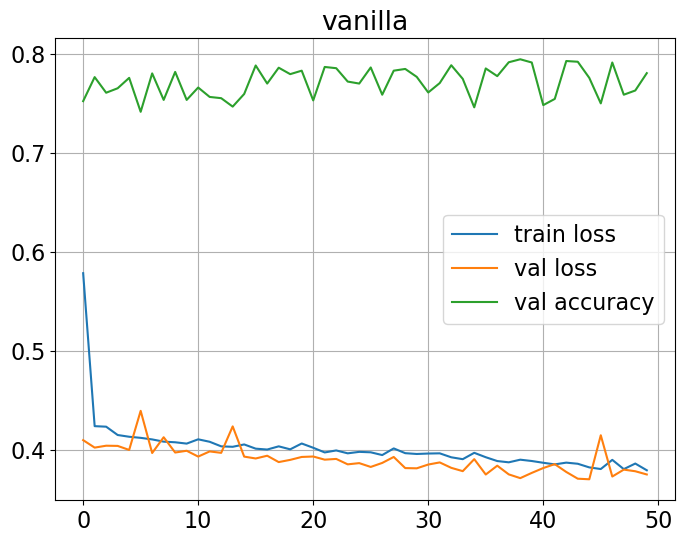

In [3]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(val_accs)
plt.legend(["train loss", "val loss", "val accuracy"])
plt.title(label)
plt.savefig(f"{model_perf_loc}/{label}_losses")

In [7]:
all_predictions = torch.load(f"{model_perf_loc}/predictions.pt")
all_predicted_probs = torch.load(f"{model_perf_loc}/predicted_probabilities.pt")
all_labels = torch.load(f"{model_perf_loc}/labels.pt")

0.8723015018666667
0.9977144426666666
0.8660303981333333
0.9994014216


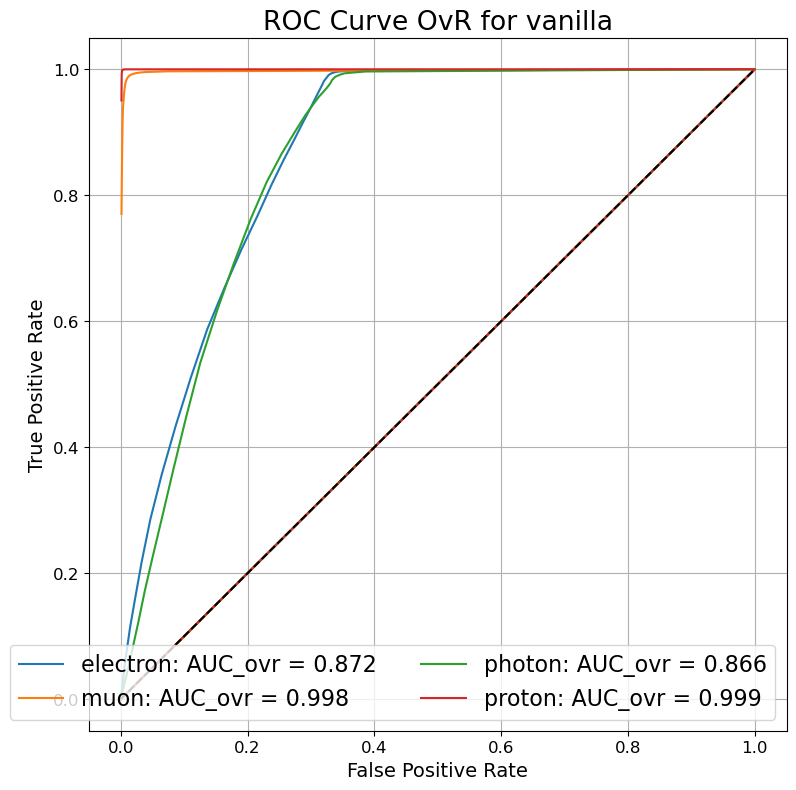

{0: 0.8723015018666667,
 1: 0.9977144426666666,
 2: 0.8660303981333333,
 3: 0.9994014216}

In [10]:
plot_overlayed_roc_curve(classes, all_labels, all_predicted_probs, class_labels, model_perf_loc, label = label)

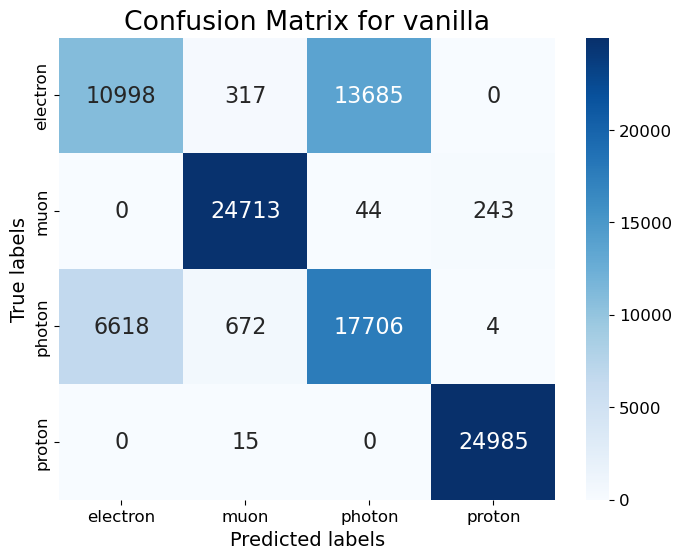

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Compute the confusion matrix
cm = confusion_matrix(all_labels.cpu(), all_predictions.cpu())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for {label}')
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
# plt.savefig(f"{model_perf_loc}/{label}_confusion_matrix")


In [11]:
mask = all_predictions != all_labels

In [12]:
misclassified = all_predictions[mask]

In [14]:
miscl_dict = {0:0, 1:0, 2:0, 3:0}
for i in range(4):
    miscl_dict[i] = torch.eq(misclassified, i).sum().item()


In [15]:
miscl_dict

{0: 3836, 1: 257, 2: 9964, 3: 21}

In [18]:
label_dict = {0: "electron", 1:"muon", 2:"photon", 3:"proton"}
for i in range(4):
    print(f"{label_dict[i]} misclassified: {miscl_dict[i]} / {(all_labels==i).sum().item()}. Rate {100 * miscl_dict[i] / (all_labels==i).sum().item():.2f}%")


electron misclassified: 3836 / 25000. Rate 15.34%
muon misclassified: 257 / 25000. Rate 1.03%
photon misclassified: 9964 / 25000. Rate 39.86%
proton misclassified: 21 / 25000. Rate 0.08%


In [6]:
all_predictions.shape

torch.Size([100000])

In [7]:
all_labels.shape

torch.Size([100000])

In [8]:
all_predicted_probs.shape

torch.Size([100000, 4])